# Imports and configs

In [1]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from autogluon.tabular import TabularPredictor
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from tabpfn import TabPFNClassifier
from xgboost import XGBClassifier
from scipy.special import logit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import optuna
import glob
import json
import os
import gc

warnings.filterwarnings("ignore")

In [2]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e3/train.csv"
    test_path = "/kaggle/input/playground-series-s5e3/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e3/sample_submission.csv"
    
    target = "rainfall"
    n_folds = 5
    seed = 42
    
    run_optuna = True
    optuna_trials = 250

# Data loading and preprocessing

In [3]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

test["winddirection"] = test["winddirection"].fillna(test["winddirection"].median())

In [4]:
X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test.copy()

# Training base models

In [5]:
class Trainer:
    def __init__(self, model, config=CFG, is_ensemble_model=False):
        self.model = model
        self.config = config
        self.is_ensemble_model = is_ensemble_model

    def fit_predict(self, X, y, X_test, X_original=None, y_original=None):
        print(f"Training {self.model.__class__.__name__}\n")
        
        scores = []        
        coeffs = np.zeros((1, X.shape[1]))
        oof_pred_probs = np.zeros(X.shape[0])
        test_pred_probs = np.zeros(X_test.shape[0])
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            if X_original is not None and y_original is not None:                            
                X_train = pd.concat([X_train, X_original], ignore_index=True)
                y_train = pd.concat([y_train, y_original], ignore_index=True)
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            if self.is_ensemble_model:
                coeffs += model.coef_ / self.config.n_folds
                if isinstance(self.model, LogisticRegression):
                    n_iters = model.n_iter_[0]
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[: ,1]
            oof_pred_probs[val_idx] = y_pred_probs 
            
            temp_test_pred_probs = model.predict(X_test) if isinstance(self.model, Ridge) else model.predict_proba(X_test)[:, 1]
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = roc_auc_score(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            if self.is_ensemble_model and isinstance(self.model, LogisticRegression):
                print(f"--- Fold {fold_idx + 1} - ROC AUC: {score:.6f} ({n_iters} iterations)")
            else:
                print(f"--- Fold {fold_idx + 1} - ROC AUC: {score:.6f}")
            
        overall_score = roc_auc_score(y, oof_pred_probs)
            
        print(f"\n------ Overall: {overall_score:.6f} | Average: {np.mean(scores):.6f} ± {np.std(scores):.6f}")
        
        if self.is_ensemble_model:
            return oof_pred_probs, test_pred_probs, scores, coeffs
        else:
            os.makedirs("oof_pred_probs", exist_ok=True)
            os.makedirs("test_pred_probs", exist_ok=True)
            self._save_pred_probs(oof_pred_probs, np.mean(scores), "oof")
            self._save_pred_probs(test_pred_probs, np.mean(scores), "test")
            return oof_pred_probs, test_pred_probs, scores
        
    def tune(self, X, y):        
        scores = []        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict(X_val) if isinstance(self.model, Ridge) else model.predict_proba(X_val)[: ,1]
            score = roc_auc_score(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        return np.mean(scores)
        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace("classifier", "")
        with open(f"{name}_pred_probs/{model_name}_{name}_pred_probs_{cv_score:.6f}.pkl", "wb") as f:
            pickle.dump(pred_probs, f)

In [6]:
def save_submission(name, test_pred_probs, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_pred_probs
    sub.to_csv(f"sub_{name}_{score:.6f}.csv", index=False)
    return sub.head()

In [7]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [8]:
xgb_params = {
    "colsample_bylevel": 0.5759002656759072,
    "colsample_bynode": 0.42460592745733416,
    "colsample_bytree": 0.6681903658062955,
    "gamma": 1.6606282492625313,
    "learning_rate": 0.05197817807184489,
    "max_depth": 177,
    "max_leaves": 208,
    "min_child_weight": 3,
    "n_estimators": 3373,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 3.647027988459395,
    "reg_lambda": 9.48338781598732,
    "subsample": 0.903408474763426,
    "verbosity": 0
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.8476377775404691,
    "learning_rate": 0.05535905415032254,
    "min_child_samples": 94,
    "min_child_weight": 0.7742412548324099,
    "n_estimators": 293,
    "n_jobs": -1,
    "num_leaves": 409,
    "random_state": 42,
    "reg_alpha": 10.371296888060456,
    "reg_lambda": 28.33161504781989,
    "subsample": 0.28341373258437474,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.8208408104268429,
    "learning_rate": 0.04530694055021972,
    "min_child_samples": 53,
    "min_child_weight": 0.9986857129449946,
    "n_estimators": 260,
    "n_jobs": -1,
    "num_leaves": 20,
    "random_state": 42,
    "reg_alpha": 2.522154852594183,
    "reg_lambda": 72.61906225209607,
    "subsample": 0.8052111283468785,
    "verbose": -1
}

cb_params = {
    "border_count": 181,
    "colsample_bylevel": 0.5017762060861627,
    "depth": 5,
    "iterations": 417,
    "l2_leaf_reg": 97.619408459123,
    "learning_rate": 0.015603843064139295,
    "min_child_samples": 438,
    "random_state": 42,
    "random_strength": 0.973489470246637,
    "subsample": 0.2777982603536663,
    "verbose": False
}

adb_params = {
    "learning_rate": 0.02849860787991116,
    "n_estimators": 421,
    "random_state": 42
}

rf_params = {
    "min_samples_leaf": 10,
    "min_samples_split": 3,
    "n_estimators": 248,
    "n_jobs": -1,
    "random_state": 42
}

et_params = {
    "class_weight": None,
    "criterion": "entropy",
    "min_samples_leaf": 3,
    "min_samples_split": 69,
    "n_estimators": 1199,
    "random_state": 42
}

histgb_params = {
    "l2_regularization": 99.57362071334332,
    "learning_rate": 0.08951727018193958,
    "max_depth": 325,
    "max_iter": 101,
    "max_leaf_nodes": 238,
    "min_samples_leaf": 80,
    "random_state": 42
}

gb_params = {
    "learning_rate": 0.014719110111196282,
    "max_depth": 42,
    "max_features": 0.785890517657601,
    "max_leaf_nodes": 41,
    "min_samples_leaf": 0.004529940310436742,
    "min_samples_split": 0.01824257250689731,
    "min_weight_fraction_leaf": 0.07901583438561444,
    "n_estimators": 193,
    "random_state": 42,
    "subsample": 0.5689877287369915
}

lr_params = {
  "random_state": 42,
  "max_iter": 500,
  "C": 32.07196413616409,
  "tol": 0.004832450591427355,
  "fit_intercept": True,
  "class_weight": None,
  "solver": "newton-cholesky",
  "penalty": None
}

In [9]:
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)
oof_pred_probs["XGBoost"], test_pred_probs["XGBoost"], scores["XGBoost"] = xgb_trainer.fit_predict(X, y, X_test)

Training XGBClassifier

--- Fold 1 - ROC AUC: 0.923737
--- Fold 2 - ROC AUC: 0.857926
--- Fold 3 - ROC AUC: 0.877441
--- Fold 4 - ROC AUC: 0.908530
--- Fold 5 - ROC AUC: 0.899355

------ Overall: 0.892126 | Average: 0.893398 ± 0.023228


In [10]:
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
oof_pred_probs["LightGBM"], test_pred_probs["LightGBM"], scores["LightGBM"] = lgbm_trainer.fit_predict(X, y, X_test)

Training LGBMClassifier

--- Fold 1 - ROC AUC: 0.926599
--- Fold 2 - ROC AUC: 0.854938
--- Fold 3 - ROC AUC: 0.873906
--- Fold 4 - ROC AUC: 0.912724
--- Fold 5 - ROC AUC: 0.904209

------ Overall: 0.892497 | Average: 0.894475 ± 0.026253


In [11]:
lgbm_goss_model = LGBMClassifier(**lgbm_goss_params)
lgbm_goss_trainer = Trainer(lgbm_goss_model)
oof_pred_probs["LightGBM (goss)"], test_pred_probs["LightGBM (goss)"], scores["LightGBM (goss)"] = lgbm_goss_trainer.fit_predict(X, y, X_test)

Training LGBMClassifier

--- Fold 1 - ROC AUC: 0.922559
--- Fold 2 - ROC AUC: 0.850028
--- Fold 3 - ROC AUC: 0.880177
--- Fold 4 - ROC AUC: 0.911841
--- Fold 5 - ROC AUC: 0.901263

------ Overall: 0.891866 | Average: 0.893173 ± 0.025721


In [12]:
cb_model = CatBoostClassifier(**cb_params)
cb_trainer = Trainer(cb_model)
oof_pred_probs["CatBoost"], test_pred_probs["CatBoost"], scores["CatBoost"] = cb_trainer.fit_predict(X, y, X_test)

Training CatBoostClassifier

--- Fold 1 - ROC AUC: 0.923934
--- Fold 2 - ROC AUC: 0.858053
--- Fold 3 - ROC AUC: 0.874467
--- Fold 4 - ROC AUC: 0.912177
--- Fold 5 - ROC AUC: 0.900224

------ Overall: 0.891793 | Average: 0.893771 ± 0.024243


In [13]:
adb_model = AdaBoostClassifier(**adb_params)
adb_trainer = Trainer(adb_model)
oof_pred_probs["AdaBoost"], test_pred_probs["AdaBoost"], scores["AdaBoost"] = adb_trainer.fit_predict(X, y, X_test)

Training AdaBoostClassifier

--- Fold 1 - ROC AUC: 0.925786
--- Fold 2 - ROC AUC: 0.846184
--- Fold 3 - ROC AUC: 0.853465
--- Fold 4 - ROC AUC: 0.901950
--- Fold 5 - ROC AUC: 0.895847

------ Overall: 0.882266 | Average: 0.884646 ± 0.030229


In [14]:
rf_model = RandomForestClassifier(**rf_params)
rf_trainer = Trainer(rf_model)
oof_pred_probs["RandomForest"], test_pred_probs["RandomForest"], scores["RandomForest"] = rf_trainer.fit_predict(X, y, X_test)

Training RandomForestClassifier

--- Fold 1 - ROC AUC: 0.925645
--- Fold 2 - ROC AUC: 0.854181
--- Fold 3 - ROC AUC: 0.871296
--- Fold 4 - ROC AUC: 0.908754
--- Fold 5 - ROC AUC: 0.901459

------ Overall: 0.890584 | Average: 0.892267 ± 0.025926


In [15]:
et_model = ExtraTreesClassifier(**et_params)
et_trainer = Trainer(et_model)
oof_pred_probs["ExtraTrees"], test_pred_probs["ExtraTrees"], scores["ExtraTrees"] = et_trainer.fit_predict(X, y, X_test)

Training ExtraTreesClassifier

--- Fold 1 - ROC AUC: 0.926263
--- Fold 2 - ROC AUC: 0.860382
--- Fold 3 - ROC AUC: 0.872615
--- Fold 4 - ROC AUC: 0.905359
--- Fold 5 - ROC AUC: 0.900168

------ Overall: 0.892296 | Average: 0.892957 ± 0.023622


In [16]:
histgb_model = HistGradientBoostingClassifier(**histgb_params)
histgb_trainer = Trainer(histgb_model)
oof_pred_probs["HistGradientBoosting"], test_pred_probs["HistGradientBoosting"], scores["HistGradientBoosting"] = histgb_trainer.fit_predict(X, y, X_test)

Training HistGradientBoostingClassifier

--- Fold 1 - ROC AUC: 0.925800
--- Fold 2 - ROC AUC: 0.855626
--- Fold 3 - ROC AUC: 0.870188
--- Fold 4 - ROC AUC: 0.911967
--- Fold 5 - ROC AUC: 0.906033

------ Overall: 0.891762 | Average: 0.893923 ± 0.026527


In [17]:
gb_model = GradientBoostingClassifier(**gb_params)
gb_trainer = Trainer(gb_model)
oof_pred_probs["GradientBoosting"], test_pred_probs["GradientBoosting"], scores["GradientBoosting"] = gb_trainer.fit_predict(X, y, X_test)

Training GradientBoostingClassifier

--- Fold 1 - ROC AUC: 0.925505
--- Fold 2 - ROC AUC: 0.851655
--- Fold 3 - ROC AUC: 0.872363
--- Fold 4 - ROC AUC: 0.909540
--- Fold 5 - ROC AUC: 0.906538

------ Overall: 0.891314 | Average: 0.893120 ± 0.027013


In [18]:
lr_model = LogisticRegression(**lr_params)
lr_trainer = Trainer(lr_model)
oof_pred_probs["LogisticRegression"], test_pred_probs["LogisticRegression"], scores["LogisticRegression"] = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - ROC AUC: 0.921409
--- Fold 2 - ROC AUC: 0.860382
--- Fold 3 - ROC AUC: 0.882379
--- Fold 4 - ROC AUC: 0.910045
--- Fold 5 - ROC AUC: 0.898064

------ Overall: 0.893404 | Average: 0.894456 ± 0.021398


In [19]:
tabpfn_model = TabPFNClassifier(random_state=CFG.seed, n_jobs=-1)
tabpfn_trainer = Trainer(tabpfn_model)
oof_pred_probs["TabPFN"], test_pred_probs["TabPFN"], scores["TabPFN"] = tabpfn_trainer.fit_predict(X, y, X_test)

Training TabPFNClassifier



tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

--- Fold 1 - ROC AUC: 0.924411
--- Fold 2 - ROC AUC: 0.857800
--- Fold 3 - ROC AUC: 0.874270
--- Fold 4 - ROC AUC: 0.912654
--- Fold 5 - ROC AUC: 0.900309

------ Overall: 0.891639 | Average: 0.893889 ± 0.024545


In [20]:
print("Running inference on AutoGluon\n")

ag_oof_files = glob.glob('/kaggle/input/s05e03-rainfall-prediction-autogluon/WeightedEnsemble_L2_oof_pred_probs_*.pkl')
ag_test_files = glob.glob('/kaggle/input/s05e03-rainfall-prediction-autogluon/WeightedEnsemble_L2_test_pred_probs_*.pkl')

ag_oof_pred_probs = pickle.load(open(ag_oof_files[0], 'rb'))
ag_test_pred_probs = pickle.load(open(ag_test_files[0], 'rb'))

ag_scores = []
split = StratifiedKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(X, y)
for fold_idx, (_, val_idx) in enumerate(split):
    y_val = y[val_idx]
    y_pred_probs = ag_oof_pred_probs[val_idx]   
    score = roc_auc_score(y_val, y_pred_probs)
    ag_scores.append(score)

    print(f"--- Fold {fold_idx + 1} - ROC AUC: {score:.6f}")
            
overall_score = roc_auc_score(y, ag_oof_pred_probs)            
print(f"\n------ Overall: {overall_score:.6f} | Average: {np.mean(ag_scores):.6f} ± {np.std(ag_scores):.6f}")
    
oof_pred_probs["AutoGluon"], test_pred_probs["AutoGluon"], scores["AutoGluon"] = ag_oof_pred_probs, ag_test_pred_probs, ag_scores

Running inference on AutoGluon

--- Fold 1 - ROC AUC: 0.930247
--- Fold 2 - ROC AUC: 0.862795
--- Fold 3 - ROC AUC: 0.877806
--- Fold 4 - ROC AUC: 0.916891
--- Fold 5 - ROC AUC: 0.902778

------ Overall: 0.899698 | Average: 0.898103 ± 0.024766


# Ensembling with LogisticRegression

In [21]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_pred_probs.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [22]:
X = logit(pd.DataFrame(oof_pred_probs).clip(1e-15, 1-1e-15))
X_test = logit(pd.DataFrame(test_pred_probs).clip(1e-15, 1-1e-15))

In [23]:
def objective(trial):
    solver_penalty_options = [
        ("liblinear", "l1"),
        ("liblinear", "l2"),
        ("lbfgs", "l2"),
        ("lbfgs", None),
        ("newton-cg", "l2"),
        ("newton-cg", None),
        ("newton-cholesky", "l2"),
        ("newton-cholesky", None)
    ]
    solver, penalty = trial.suggest_categorical("solver_penalty", solver_penalty_options)
    
    params = {
        "random_state": CFG.seed,
        "max_iter": 500,
        "C": trial.suggest_float("C", 0, 100),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced", None]),
        "solver": solver,
        "penalty": penalty
    }
    
    model = LogisticRegression(**params)
    trainer = Trainer(model, is_ensemble_model=True)
    return trainer.tune(X, y)

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True, n_startup_trials=CFG.optuna_trials // 10)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.optuna_trials, n_jobs=-1)
    best_params = study.best_params
    
    solver, penalty = best_params["solver_penalty"]
    lr_params = {
        "random_state": CFG.seed,
        "max_iter": 500,
        "C": best_params["C"],
        "tol": best_params["tol"],
        "fit_intercept": best_params["fit_intercept"],
        "class_weight": best_params["class_weight"],
        "solver": solver,
        "penalty": penalty
    }
else:
    lr_params = {
        "random_state": CFG.seed,
        "max_iter": 500
    }

[I 2025-03-10 15:15:58,279] A new study created in memory with name: no-name-77099ed8-7bf8-499e-8db3-8f24519f66c5
[I 2025-03-10 15:16:01,250] Trial 3 finished with value: 0.8957912457912457 and parameters: {'solver_penalty': ('liblinear', 'l2'), 'C': 58.17636794930446, 'tol': 0.00011539801475081298, 'fit_intercept': True, 'class_weight': None}. Best is trial 3 with value: 0.8957912457912457.
[I 2025-03-10 15:16:01,909] Trial 0 finished with value: 0.8835297418630752 and parameters: {'solver_penalty': ('liblinear', 'l1'), 'C': 35.99838064721139, 'tol': 0.0009417944320295883, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.8957912457912457.
[I 2025-03-10 15:16:02,168] Trial 2 finished with value: 0.8954882154882154 and parameters: {'solver_penalty': ('newton-cholesky', None), 'C': 61.30829433293017, 'tol': 0.006326194867671631, 'fit_intercept': True, 'class_weight': 'balanced'}. Best is trial 3 with value: 0.8957912457912457.
[I 2025-03-10 15:16:03,776]

In [24]:
print(json.dumps(lr_params, indent=2))

{
  "random_state": 42,
  "max_iter": 500,
  "C": 71.99626688338633,
  "tol": 0.008546150584027787,
  "fit_intercept": true,
  "class_weight": "balanced",
  "solver": "lbfgs",
  "penalty": null
}


In [25]:
lr_model = LogisticRegression(**lr_params)
lr_trainer = Trainer(lr_model, is_ensemble_model=True)
lr_oof_pred_probs, lr_test_pred_probs, scores["Ensemble LR"], lr_coeffs = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - ROC AUC: 0.927413 (13 iterations)
--- Fold 2 - ROC AUC: 0.860017 (8 iterations)
--- Fold 3 - ROC AUC: 0.879966 (9 iterations)
--- Fold 4 - ROC AUC: 0.915516 (9 iterations)
--- Fold 5 - ROC AUC: 0.901964 (9 iterations)

------ Overall: 0.896306 | Average: 0.896975 ± 0.024291


In [26]:
save_submission("ensemble-lr", lr_test_pred_probs, np.mean(scores["Ensemble LR"]))

,id,rainfall
0,2190,0.952256
1,2191,0.962242
2,2192,0.816636
3,2193,0.029133
4,2194,0.017815


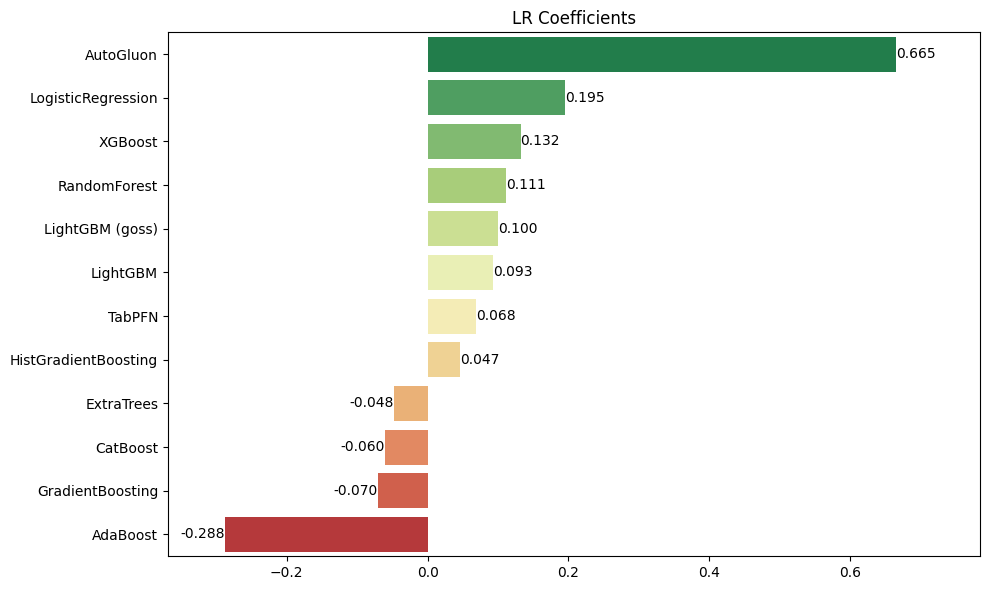

In [27]:
plot_weights(lr_coeffs, "LR Coefficients")

# Ensembling with Ridge

In [28]:
X = pd.DataFrame(oof_pred_probs)
X_test = pd.DataFrame(test_pred_probs)

In [29]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 25),
        "tol": trial.suggest_float("tol", 1e-7, 1e-2),
        "positive": trial.suggest_categorical("positive", [True, False]),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False])
    }
    
    model = Ridge(**params)
    trainer = Trainer(model, is_ensemble_model=True)
    return trainer.tune(X, y)

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True, n_startup_trials=CFG.optuna_trials // 10)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.optuna_trials, n_jobs=-1)
    best_params = study.best_params
    
    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"],
        "positive": best_params["positive"],
        "fit_intercept": best_params["fit_intercept"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-03-10 15:20:49,969] A new study created in memory with name: no-name-65ba23b9-99f0-46c8-bb51-be8f71a8b9df
[I 2025-03-10 15:20:53,527] Trial 1 finished with value: 0.8964870931537599 and parameters: {'alpha': 14.736110720116075, 'tol': 0.0034428262159275787, 'positive': False, 'fit_intercept': True}. Best is trial 1 with value: 0.8964870931537599.
[I 2025-03-10 15:20:53,529] Trial 3 finished with value: 0.8968462401795735 and parameters: {'alpha': 20.877518616251386, 'tol': 0.000175631974967891, 'positive': False, 'fit_intercept': False}. Best is trial 3 with value: 0.8968462401795735.
[I 2025-03-10 15:20:54,424] Trial 2 finished with value: 0.8962457912457914 and parameters: {'alpha': 22.907789319204536, 'tol': 0.008732279380078077, 'positive': True, 'fit_intercept': True}. Best is trial 3 with value: 0.8968462401795735.
[I 2025-03-10 15:20:54,878] Trial 0 finished with value: 0.8962457912457914 and parameters: {'alpha': 23.897283273765485, 'tol': 0.00842727407454524, 'positive

In [30]:
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 2.1747521089472017,
  "tol": 0.005674002824493711,
  "positive": false,
  "fit_intercept": false
}


In [31]:
ridge_model = Ridge(**ridge_params)
ridge_trainer = Trainer(ridge_model, is_ensemble_model=True)
lr_oof_pred_probs, lr_test_pred_probs, scores["Ensemble Ridge"], ridge_coeffs = ridge_trainer.fit_predict(X, y, X_test)

Training Ridge

--- Fold 1 - ROC AUC: 0.929040
--- Fold 2 - ROC AUC: 0.860101
--- Fold 3 - ROC AUC: 0.880836
--- Fold 4 - ROC AUC: 0.915236
--- Fold 5 - ROC AUC: 0.902160

------ Overall: 0.897284 | Average: 0.897475 ± 0.024525


In [32]:
save_submission("ensemble-ridge", lr_test_pred_probs, np.mean(scores["Ensemble Ridge"]))

,id,rainfall
0,2190,0.972602
1,2191,0.975720
2,2192,0.935303
3,2193,0.105440
4,2194,0.071295


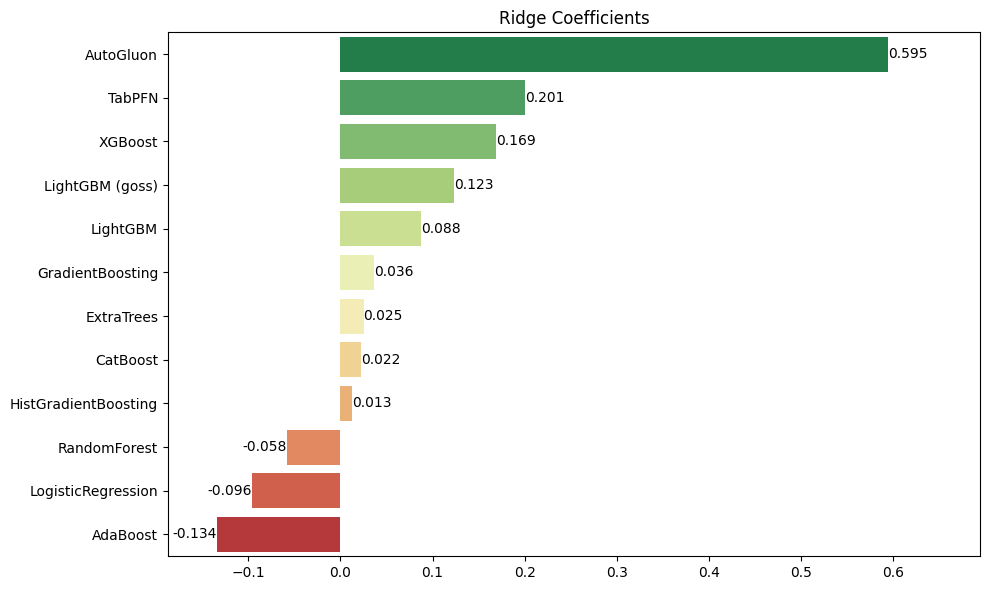

In [33]:
plot_weights(ridge_coeffs, "Ridge Coefficients")

# Results

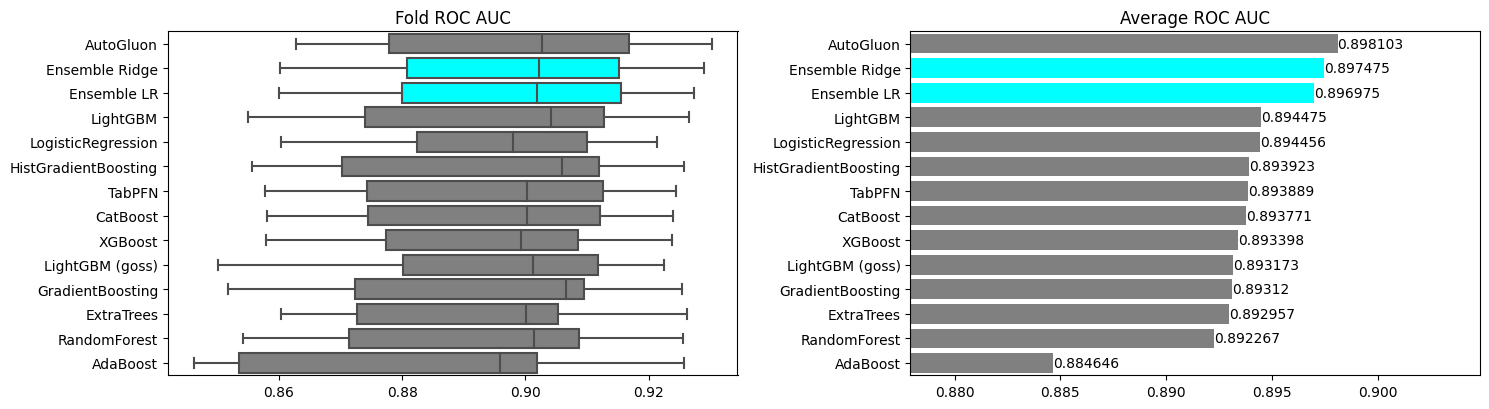

In [34]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title("Fold ROC AUC")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title("Average ROC AUC")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

In [35]:
shutil.rmtree("catboost_info", ignore_errors=True)